# 6장 이진 분류

* "부록3 매트플롯립 입문"에서 한글 폰트를 올바르게 출력하기 위한 설치 방법을 설명했다. 설치 방법은 다음과 같다.

In [ ]:
!sudo apt-get install -y fonts-nanum* | tail -n 1
!sudo fc-cache -fv
!rm -rf ~/.cache/matplotlib

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 4.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 31 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such 

In [ ]:
# 필요 라이브러리 설치

!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1

* 모든 설치가 끝나면 한글 폰트를 바르게 출력하기 위해 **[런타임]** -> **[런타임 다시시작]**을 클릭한 다음, 아래 셀부터 코드를 실행해 주십시오.

In [ ]:
# 라이브러리 임포트

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# 폰트 관련 용도
import matplotlib.font_manager as fm

# 나눔 고딕 폰트의 경로 명시
path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()

In [ ]:
# 파이토치 관련 라이브러리

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot

In [ ]:
# 기본 폰트 설정
plt.rcParams['font.family'] = font_name

# 기본 폰트 사이즈 변경
plt.rcParams['font.size'] = 14

# 기본 그래프 사이즈 변경
plt.rcParams['figure.figsize'] = (6,6)

# 기본 그리드 표시
# 필요에 따라 설정할 때는, plt.grid()
plt.rcParams['axes.grid'] = True

# 마이너스 기호 정상 출력
plt.rcParams['axes.unicode_minus'] = False

# 넘파이 부동소수점 자릿수 표시
np.set_printoptions(suppress=True, precision=4)

## 6.5 시그모이드 함수

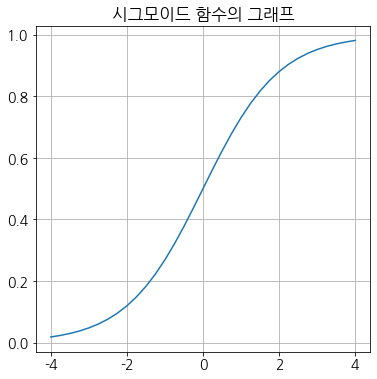

In [ ]:
# 넘파이 배열로 x_np를 정의
x_np = np.arange(-4, 4.1, 0.25)

# x_np를 텐서로 변환
x = torch.tensor(x_np).float()

# y값 계산
y = torch.sigmoid(x)

# 그래프 출력
plt.title('시그모이드 함수의 그래프')
plt.plot(x.data, y.data)
plt.show()

## 6.7 데이터 준비

In [ ]:
# 학습용 데이터 준비

# 라이브러리 임포트
from sklearn.datasets import load_iris

# 데이터 불러오기
iris = load_iris()

# 입력 데이터와 정답 데이터
x_org, y_org = iris.data, iris.target

# 결과 확인
print('원본 데이터', x_org.shape, y_org.shape)

원본 데이터 (150, 4) (150,)


In [ ]:
# 데이터 추출
# 클래스는 0 또는 1
# 항목은 sepal_length와 sepal_width

x_data = iris.data[:100,:2]
y_data = iris.target[:100]

# 결과 확인
print('대상 데이터', x_data.shape, y_data.shape)

대상 데이터 (100, 2) (100,)


### 훈련 데이터와 검증 데이터 분할

In [ ]:
# 원본 데이터의 사이즈
print(x_data.shape, y_data.shape)

# 훈련 데이터와 검증 데이터로 분할(동시에 셔플)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, train_size=70, test_size=30, 
    random_state=123)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(100, 2) (100,)
(70, 2) (30, 2) (70,) (30,)


### 훈련 데이터의 산포도 출력

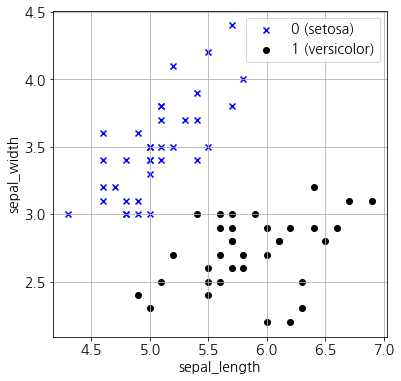

In [ ]:
# 산포도 출력

x_t0 = x_train[y_train == 0]
x_t1 = x_train[y_train == 1]
plt.scatter(x_t0[:,0], x_t0[:,1], marker='x', c='b', label='0 (setosa)')
plt.scatter(x_t1[:,0], x_t1[:,1], marker='o', c='k', label='1 (versicolor)')
plt.xlabel('sepal_length')
plt.ylabel('sepal_width')
plt.legend()
plt.show()

## 6.8 모델 정의

In [ ]:
# 입력 차원수(지금의 경우는 2)
n_input= x_train.shape[1]

# 출력 차원수
n_output = 1

# 결과 확인
print(f'n_input: {n_input}  n_output:{n_output}')

n_input: 2  n_output:1


In [ ]:
# 모델 정의
# 2입력 1출력 로지스틱 회귀 모델

class Net(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()
        self.l1 = nn.Linear(n_input, n_output)
        self.sigmoid = nn.Sigmoid()
                
        # 초깃값을 전부 1로 함
        # "딥러닝을 위한 수학"과 조건을 맞추기 위한 목적        
        self.l1.weight.data.fill_(1.0)
        self.l1.bias.data.fill_(1.0)        
        
    # 예측 함수 정의
    def forward(self, x):
        # 선형 함수에 입력값을 넣고 계산한 결과
        x1 = self.l1(x)
        # 계산 결과에 시그모이드 함수를 적용
        x2 = self.sigmoid(x1)
        return x2

In [ ]:
# 인스턴스 생성

net = Net(n_input, n_output)

### 모델 확인

In [ ]:
# 모델 안의 파라미터 확인
# l1.weight와 l1.bias가 존재함을 알 수 있음

for parameter in net.named_parameters():
    print(parameter)

('l1.weight', Parameter containing:
tensor([[1., 1.]], requires_grad=True))
('l1.bias', Parameter containing:
tensor([1.], requires_grad=True))


In [ ]:
# 모델의 개요 표시 1

print(net)

Net(
  (l1): Linear(in_features=2, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [ ]:
# 모델의 개요 표시 2

summary(net, (2,))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      --                        --
├─Linear: 1-1                            [1]                       3
├─Sigmoid: 1-2                           [1]                       --
Total params: 3
Trainable params: 3
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

### 최적화 알고리즘과 손실 함수의 정의

In [ ]:
# 손실 함수： 교차 엔트로피 함수
criterion = nn.BCELoss()

# 학습률
lr = 0.01

# 최적화 함수: 경사 하강법
optimizer = optim.SGD(net.parameters(), lr=lr)

## 6.9 경사 하강법

In [ ]:
# 입력 데이터 x_train과 정답 데이터 y_train의 텐서화

inputs = torch.tensor(x_train).float()
labels = torch.tensor(y_train).float()

# 정답 데이터는 N행 1열 행렬로 변환
labels1 = labels.view((-1,1))

# 검증 데이터의 텐서화
inputs_test = torch.tensor(x_test).float()
labels_test = torch.tensor(y_test).float()

# 검증용 정답 데이터도 N행 1열 행렬로 변환
labels1_test = labels_test.view((-1,1))

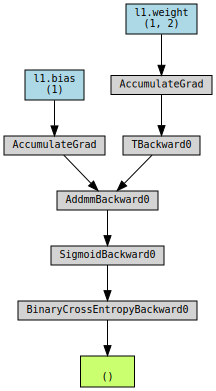

In [ ]:
# 예측 계산
outputs = net(inputs)

# 손실 계산
loss = criterion(outputs, labels1)

# 손실을 계산 그래프로 출력
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

### 반복 계산

In [ ]:
# 학습률
lr = 0.01

# 초기화
net = Net(n_input, n_output)

# 손실 함수： 교차 엔트로피 함수
criterion = nn.BCELoss()

# 최적화 함수: 경사 하강법
optimizer = optim.SGD(net.parameters(), lr=lr)

# 반복 횟수
num_epochs = 10000

# 기록용 리스트 초기화
history = np.zeros((0,5))

In [ ]:
# 반복 계산 메인 루프

for epoch in range(num_epochs):
    # 훈련 페이즈
    
    # 경삿값 초기화
    optimizer.zero_grad()

    # 예측 계산
    outputs = net(inputs)

    # 손실 계산
    loss = criterion(outputs, labels1)

    # 경사 계산
    loss.backward()
    
    # 파라미터 수정
    optimizer.step()

    # 손실 저장(스칼라 값 취득)
    train_loss = loss.item()

    # 예측 라벨(1 또는 0) 계산
    predicted = torch.where(outputs < 0.5, 0, 1)
    
    # 정확도 계산
    train_acc = (predicted == labels1).sum() / len(y_train)

    # 예측 페이즈

    # 예측 계산
    outputs_test = net(inputs_test)

    # 손실 계산
    loss_test = criterion(outputs_test, labels1_test)

    # 손실 저장(스칼라 값 취득)
    val_loss =  loss_test.item()
        
    # 예측 라벨(1 또는 0) 계산
    predicted_test = torch.where(outputs_test < 0.5, 0, 1)

    # 정확도 계산
    val_acc = (predicted_test == labels1_test).sum() / len(y_test)
    
    if ( epoch % 10 == 0):
        print (f'Epoch [{epoch}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
        item = np.array([epoch, train_loss, train_acc, val_loss, val_acc])
        history = np.vstack((history, item))

Epoch [0/10000], loss: 4.77289 acc: 0.50000 val_loss: 4.49384, val_acc: 0.50000
Epoch [10/10000], loss: 3.80546 acc: 0.50000 val_loss: 3.56537, val_acc: 0.50000
Epoch [20/10000], loss: 2.84329 acc: 0.50000 val_loss: 2.64328, val_acc: 0.50000
Epoch [30/10000], loss: 1.91613 acc: 0.50000 val_loss: 1.76244, val_acc: 0.50000
Epoch [40/10000], loss: 1.17137 acc: 0.50000 val_loss: 1.08537, val_acc: 0.50000
Epoch [50/10000], loss: 0.84140 acc: 0.50000 val_loss: 0.81872, val_acc: 0.50000
Epoch [60/10000], loss: 0.77087 acc: 0.50000 val_loss: 0.77093, val_acc: 0.50000
Epoch [70/10000], loss: 0.75450 acc: 0.34286 val_loss: 0.76105, val_acc: 0.33333
Epoch [80/10000], loss: 0.74542 acc: 0.25714 val_loss: 0.75447, val_acc: 0.20000
Epoch [90/10000], loss: 0.73734 acc: 0.24286 val_loss: 0.74778, val_acc: 0.16667
Epoch [100/10000], loss: 0.72949 acc: 0.24286 val_loss: 0.74098, val_acc: 0.13333
Epoch [110/10000], loss: 0.72180 acc: 0.27143 val_loss: 0.73419, val_acc: 0.16667
Epoch [120/10000], loss: 0.

## 6.10 결과 확인

In [ ]:
# 손실과 정확도 확인

print(f'초기 상태 : 손실 : {history[0,3]:.5f}  정확도 : {history[0,4]:.5f}' )
print(f'최종 상태 : 손실 : {history[-1,3]:.5f}  정확도 : {history[-1,4]:.5f}' )

초기 상태 : 손실 : 4.49384  정확도 : 0.50000
최종 상태 : 손실 : 0.15395  정확도 : 0.96667


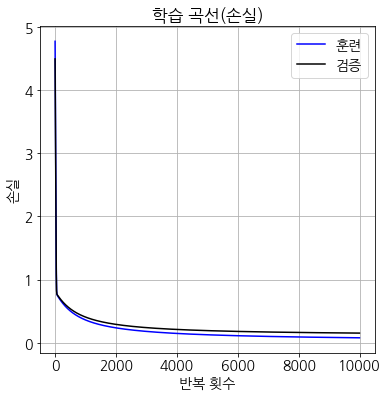

In [ ]:
# 학습 곡선 출력(손실)

plt.plot(history[:,0], history[:,1], 'b', label='훈련')
plt.plot(history[:,0], history[:,3], 'k', label='검증')
plt.xlabel('반복 횟수')
plt.ylabel('손실')
plt.title('학습 곡선(손실)')
plt.legend()
plt.show()

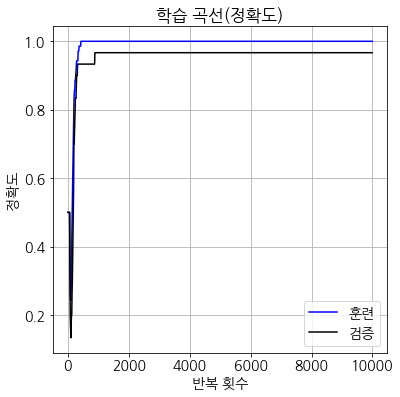

In [ ]:
# 학습 곡선 출력(정확도)

plt.plot(history[:,0], history[:,2], 'b', label='훈련')
plt.plot(history[:,0], history[:,4], 'k', label='검증')
plt.xlabel('반복 횟수')
plt.ylabel('정확도')
plt.title('학습 곡선(정확도)')
plt.legend()
plt.show()

### 결정  경계 그래프 출력

In [ ]:
# 검증 데이터 준비

x_t0 = x_test[y_test==0]
x_t1 = x_test[y_test==1]

In [ ]:
# 파라미터 취득

bias = net.l1.bias.data.numpy()
weight = net.l1.weight.data.numpy()
print(f'BIAS = {bias}, WEIGHT = {weight}')

# 결정 경계를 그리기 위해 x1로부터 x2를 계산
def decision(x):
    return(-(bias + weight[0,0] * x)/ weight[0,1])

# 산포도의 x1의 최솟값과 최댓값
xl = np.array([x_test[:,0].min(), x_test[:,0].max()])
yl = decision(xl)

# 결과 확인
print(f'xl = {xl}  yl = {yl}')

BIAS = [0.3386], WEIGHT = [[ 2.97 -5.3 ]]
xl = [4.4 7. ]  yl = [2.5296 3.9866]


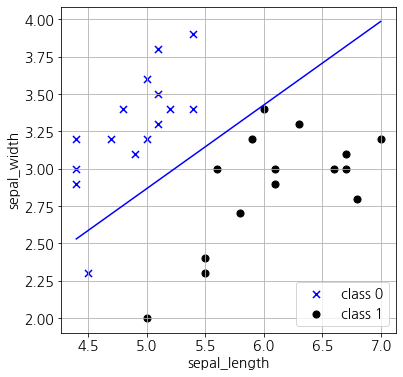

In [ ]:
# 산포도 출력
plt.scatter(x_t0[:,0], x_t0[:,1], marker='x', 
        c='b', s=50, label='class 0')
plt.scatter(x_t1[:,0], x_t1[:,1], marker='o', 
        c='k', s=50, label='class 1')

# 결정 경계 직선
plt.plot(xl, yl, c='b')
plt.xlabel('sepal_length')
plt.ylabel('sepal_width')
plt.legend()
plt.show()

## 칼럼 BCELoss 함수와 BCEWithLogitsLoss 함수의 차이

In [ ]:
# 모델 정의
# 2입력 1출력 로지스틱 회귀 모델

class Net(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()
        self.l1 = nn.Linear(n_input, n_output)
                
        # 초깃값을 모두 1로 함
        # "딥러닝을 위한 수학"과 조건을 맞추기 위한 목적        
        self.l1.weight.data.fill_(1.0)
        self.l1.bias.data.fill_(1.0)        
        
    # 예측 함수 정의
    def forward(self, x):
        # 입력 값과 행렬 곱을 계산
        x1 = self.l1(x)
        return x1

In [ ]:
# 학습률
lr = 0.01

# 초기화
net = Net(n_input, n_output)

# 손실 함수 ： logits가 붙은 교차 엔트로피 함수
criterion = nn.BCEWithLogitsLoss()

# 최적화 함수 : 경사 하강법
optimizer = optim.SGD(net.parameters(), lr=lr)

# 반복 횟수
num_epochs = 10000

# 기록용 리스트 초기화
history = np.zeros((0,5))

In [ ]:
# 반복 계산 메인 루프

for epoch in range(num_epochs):
    # 훈련 페이즈
    
    # 경삿값 초기화
    optimizer.zero_grad()

    # 예측 계산
    outputs = net(inputs)

    # 손실 계산
    loss = criterion(outputs, labels1)

    # 경사 계산
    loss.backward()
    
    # 파라미터 수정
    optimizer.step()

    # 손실값 스칼라화
    train_loss = loss.item()

    # 예측 라벨(1 또는 0) 계산
    predicted = torch.where(outputs < 0.0, 0, 1)
    
    # 정확도 계산
    train_acc = (predicted == labels1).sum() / len(y_train)

    # 예측 페이즈
    
    # 예측 계산
    outputs_test = net(inputs_test)

    # 손실 계산
    loss_test = criterion(outputs_test, labels1_test)

    # 손실값 스칼라화
    val_loss =  loss_test.item()
        
    # 예측 라벨(1 또는 0) 계산
    predicted_test = torch.where(outputs_test < 0.0, 0, 1)

    # 정확도 계산
    val_acc = (predicted_test == labels1_test).sum() / len(y_test)
    
    if ( epoch % 10 == 0):
        print (f'Epoch [{epoch}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
        item = np.array([epoch, train_loss, train_acc, val_loss, val_acc])
        history = np.vstack((history, item))

Epoch [0/10000], loss: 4.77294 acc: 0.50000 val_loss: 4.49384, val_acc: 0.50000
Epoch [10/10000], loss: 3.80546 acc: 0.50000 val_loss: 3.56537, val_acc: 0.50000
Epoch [20/10000], loss: 2.84328 acc: 0.50000 val_loss: 2.64328, val_acc: 0.50000
Epoch [30/10000], loss: 1.91613 acc: 0.50000 val_loss: 1.76244, val_acc: 0.50000
Epoch [40/10000], loss: 1.17137 acc: 0.50000 val_loss: 1.08537, val_acc: 0.50000
Epoch [50/10000], loss: 0.84140 acc: 0.50000 val_loss: 0.81872, val_acc: 0.50000
Epoch [60/10000], loss: 0.77087 acc: 0.50000 val_loss: 0.77093, val_acc: 0.50000
Epoch [70/10000], loss: 0.75450 acc: 0.34286 val_loss: 0.76105, val_acc: 0.33333
Epoch [80/10000], loss: 0.74542 acc: 0.25714 val_loss: 0.75447, val_acc: 0.20000
Epoch [90/10000], loss: 0.73734 acc: 0.24286 val_loss: 0.74778, val_acc: 0.16667
Epoch [100/10000], loss: 0.72949 acc: 0.24286 val_loss: 0.74098, val_acc: 0.13333
Epoch [110/10000], loss: 0.72180 acc: 0.27143 val_loss: 0.73419, val_acc: 0.16667
Epoch [120/10000], loss: 0.

In [ ]:
# 손실과 정확도 확인

print(f'초기 상태 : 손실 : {history[0,3]:.5f}  정확도 : {history[0,4]:.5f}' )
print(f'최종 상태 : 손실 : {history[-1,3]:.5f}  정확도 : {history[-1,4]:.5f}' )

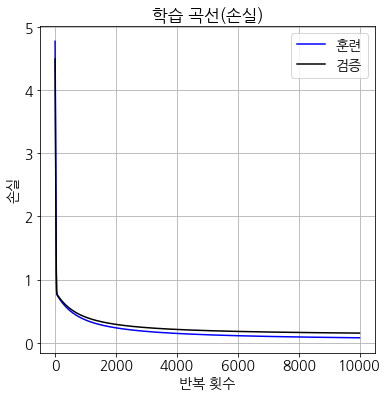

In [ ]:
# 학습 곡선 표시(손실)

plt.plot(history[:,0], history[:,1], 'b', label='훈련')
plt.plot(history[:,0], history[:,3], 'k', label='검증')
plt.xlabel('반복 횟수')
plt.ylabel('손실')
plt.title('학습 곡선(손실)')
plt.legend()
plt.show()

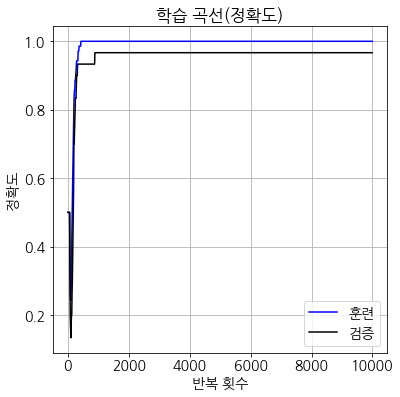

In [ ]:
# 학습 곡선 출력(정확도)

plt.plot(history[:,0], history[:,2], 'b', label='훈련')
plt.plot(history[:,0], history[:,4], 'k', label='검증')
plt.xlabel('반복 횟수')
plt.ylabel('정확도')
plt.title('학습 곡선(정확도)')
plt.legend()
plt.show()

In [ ]:
# 파라미터 취득

bias = net.l1.bias.data.numpy()
weight = net.l1.weight.data.numpy()
print(f'BIAS = {bias}, WEIGHT = {weight}')

# 결정 경계를 그리기 위해 x1로부터 x2를 계산
def decision(x):
    return(-(bias + weight[0,0] * x)/ weight[0,1])

# 산포도의 x1의 최솟값과 최댓값
xl = np.array([x_test[:,0].min(), x_test[:,0].max()])
yl = decision(xl)

# 결과 확인
print(f'xl = {xl}  yl = {yl}')

BIAS = [0.3386], WEIGHT = [[ 2.97 -5.3 ]]
xl = [4.4 7. ]  yl = [2.5296 3.9866]


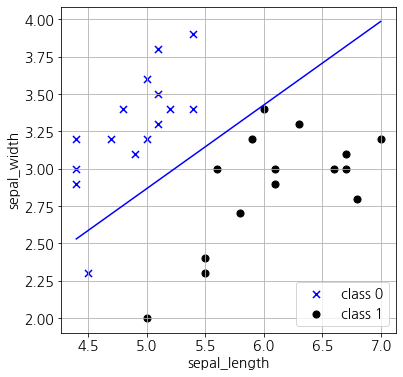

In [ ]:
# 산포도 출력
plt.scatter(x_t0[:,0], x_t0[:,1], marker='x', 
        c='b', s=50, label='class 0')
plt.scatter(x_t1[:,0], x_t1[:,1], marker='o', 
        c='k', s=50, label='class 1')

# 결정 경계 직선
plt.plot(xl, yl, c='b')
plt.xlabel('sepal_length')
plt.ylabel('sepal_width')
plt.legend()
plt.show()